<a href="https://colab.research.google.com/github/prstevens910/exploreAppleHealthDat_Sp25/blob/main/HealthDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview

The goal of this project is to use health data (downloaded from my iPhone's Health app) to make some observations about the way my activity and biometrics vary over time - rhythms for weekdays versus weekends, winter versus summer, etc.


## Data loading

The app initially exported data as an .xml file with a lot of metadata and empty lines - I cleaned this up a bit in R before loading it here, making it a .csv format, but we'll still have some pre-processing to do.


In [ ]:
import pandas as pd

df = pd.read_csv('cleaned_health_dat.csv')
display(df.head())

,recordType,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value
0,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 16:16:55 -0600,2018-05-17 15:34:08 -0600,2018-05-17 15:43:56 -0600,10.0
1,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 16:16:55 -0600,2018-05-17 15:47:44 -0600,2018-05-17 15:56:51 -0600,98.0
2,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:19:03 -0600,2018-05-17 16:29:01 -0600,242.0
3,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:29:01 -0600,2018-05-17 16:39:01 -0600,524.0
4,StepCount,iPhone (73),"11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;,...",count,2018-05-17 17:10:51 -0600,2018-05-17 16:39:01 -0600,2018-05-17 16:41:42 -0600,65.0


## Data exploration & pre-processing
Explore the loaded dataset to understand its structure, identify relevant columns, check for missing values or inconsistencies, and identify if any variables need to be reformatted or mutated to get useful information.


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("\n** Missing Values: **\n", missing_values)

# Inspect data types
print("\n** Data Types: **")
print(df.dtypes)


** Missing Values: **
 recordType       0
sourceName       0
sourceVersion    0
unit             0
creationDate     0
startDate        0
endDate          0
value            0
dtype: int64

** Data Types: **
recordType        object
sourceName        object
sourceVersion     object
unit              object
creationDate      object
startDate         object
endDate           object
value            float64
dtype: object


No missing data for any of the variables, which makes things easier. <br> One thing that immediately stands out to me is that the date variables (`creationDate`, `startDate`, `endDate`) are not recognized as dates. Let's fix that first - what date format are these variables using?

In [ ]:
print("\nUnique values in 'startDate' (first 5):\n", df['startDate'].unique()[:5])
print("\nFor 'endDate':\n", df['endDate'].unique()[:5])
print("\nFor 'creationDate':\n", df['creationDate'].unique()[:5])


Unique values in 'startDate' (first 5):
 ['2018-05-17 15:34:08 -0600' '2018-05-17 15:47:44 -0600'
 '2018-05-17 16:19:03 -0600' '2018-05-17 16:29:01 -0600'
 '2018-05-17 16:39:01 -0600']

For 'endDate':
 ['2018-05-17 15:43:56 -0600' '2018-05-17 15:56:51 -0600'
 '2018-05-17 16:29:01 -0600' '2018-05-17 16:39:01 -0600'
 '2018-05-17 16:41:42 -0600']

For 'creationDate':
 ['2018-05-17 16:16:55 -0600' '2018-05-17 17:10:51 -0600'
 '2018-05-17 18:17:11 -0600' '2018-05-17 19:14:17 -0600'
 '2018-05-17 20:12:46 -0600']


These time stamps are structured as date - time - UTC offset, or in the language of Pandas, `'%Y-%m-%d %H:%M:%S %z'`, so let's format them that way for easier processing later.

In [ ]:

try:
  df['startDate'] = pd.to_datetime(df['startDate'], format='%Y-%m-%d %H:%M:%S %z')
  df['endDate'] = pd.to_datetime(df['endDate'], format='%Y-%m-%d %H:%M:%S %z')
  df['creationDate'] = pd.to_datetime(df['creationDate'], format='%Y-%m-%d %H:%M:%S %z')
except:
  'Failed to convert one of dates to provided format'

# check that all "Year" values from these dates are reasonable, given that data is all from 2018 to 2025
print("\nUnique years from 'startDate':\n", df['startDate'].dt.year.unique())
print("\nFrom 'endDate':\n", df['endDate'].dt.year.unique())
print("\nFrom 'creationDate':\n", df['creationDate'].dt.year.unique())




Unique years from 'startDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]

From 'endDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]

From 'creationDate':
 [2018 2019 2020 2021 2022 2023 2024 2025]


It looks like all the date variables have been properly formatted. Next, let's look closer at what kinds of information `recordType`,`sourceName`, `sourceVersion`, and `unit` contain.

In [ ]:
print("\nUnique values in 'recordType':\n", df['recordType'].unique())
print("\nUnique values in 'sourceName':\n", df['sourceName'].unique())
print("\nUnique values in 'sourceVersion':\n", df['sourceVersion'].unique())
print("\nUnique values in 'unit':\n", df['unit'].unique())


Unique values in 'recordType':
 ['StepCount' 'DistanceWalkingRunning' 'BasalEnergyBurned'
 'ActiveEnergyBurned' 'FlightsClimbed' 'HeadphoneAudioExposure'
 'WalkingDoubleSupportPercentage' 'WalkingSpeed' 'WalkingStepLength'
 'WalkingAsymmetryPercentage' 'AppleWalkingSteadiness']

Unique values in 'sourceName':
 ['iPhone (73)']

Unique values in 'sourceVersion':
 ['11.3 device=&lt;&lt;HKDevice: 0x461c34500&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3, creation date:2018-05-17 21:40:10 +0000&gt;'
 '11.3 device=&lt;&lt;HKDevice: 0x461c34780&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3, creation date:2018-05-17 21:40:10 +0000&gt;'
 '11.3.1 device=&lt;&lt;HKDevice: 0x461c36e40&gt;, name:iPhone, manufacturer:Apple, model:iPhone, hardware:iPhone10,4, software:11.3.1, creation date:2018-05-24 05:02:16 +0000&gt;'
 ...
 '2956.0.7 device=&lt;&lt;HKDevice: 0x4617a2850&gt;, name:iPhone, manufacturer:Apple Inc., mode

The unique values for `recordType` and `unit` are reasonably self-explanatory (providing the metric for that row as well as the units in which it's measured), and `sourceName` is always the same. <br><br>
`sourceVersion`, on the other hand, appears to contain a variety of types of information that might be worth separating out. For example, it might be interesting to investigate how new hardware (i.e., when I upgraded from iPhone 10 to iPhone 13) might impact precision or biases of these metrics. We can create new variables by splitting the `sourceVersion` string on ", ":

In [ ]:
import numpy as np
df['rowInd'] = np.arange(df.shape[0]) # add row index for main data frame, for data re-merging later.

df2 = pd.DataFrame(df[['rowInd','sourceVersion']].copy())

# split up strings and assign to new variables
df2['text_split'] = df2['sourceVersion'].str.split(', ',n=-1)
df2 = df2.explode('text_split')
df2[['var','val']] = df2['text_split'].str.split(':',n=1,expand=True)

# filter out the source version preamble and creation date, don't care about those
df2 = df2.loc[df2['var'].isin(['name', 'manufacturer', 'model', 'hardware', 'software'])]# NOTE: svName is where headphone types can be distinguished.

# pivot so 'var' values become columns, rename columns
pivoted_df = df2.pivot(index='rowInd', columns='var', values='val')
pivoted_df = pivoted_df.rename(columns={'name': 'svName','hardware': 'svHardware','software': 'svSoftware','manufacturer': 'svManufacturer','model': 'svModel'})

# # Merge pivoted data back to the original DataFrame
df_sp = pd.merge(df, pivoted_df, left_index=True, right_on='rowInd', how='left')
df_sp = df_sp.drop(columns = ['rowInd','sourceVersion'])

# Display the updated DataFrame
display(df_sp.head())

,recordType,sourceName,unit,creationDate,startDate,endDate,value,svHardware,svManufacturer,svModel,svName,svSoftware
rowInd,,,,,,,,,,,,
0,StepCount,iPhone (73),count,2018-05-17 16:16:55-06:00,2018-05-17 15:34:08-06:00,2018-05-17 15:43:56-06:00,10.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
1,StepCount,iPhone (73),count,2018-05-17 16:16:55-06:00,2018-05-17 15:47:44-06:00,2018-05-17 15:56:51-06:00,98.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
2,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:19:03-06:00,2018-05-17 16:29:01-06:00,242.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
3,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:29:01-06:00,2018-05-17 16:39:01-06:00,524.0,"iPhone10,4",Apple,iPhone,iPhone,11.3
4,StepCount,iPhone (73),count,2018-05-17 17:10:51-06:00,2018-05-17 16:39:01-06:00,2018-05-17 16:41:42-06:00,65.0,"iPhone10,4",Apple,iPhone,iPhone,11.3


Now that we've successfully split up the `sourceVersion` values into several more informative variables, let's take a look at how `value` varies across the different values of `recordType`.

First, notice how in the data frame above there are step count records on May 17th, 2018 for 3:34 to 3:43 pm, 3:47 to 3:56 pm, etc. Let's see if the duration is consistent across these records (making them comparable).

In [ ]:
df_sp['recordDur'] = df_sp['endDate'] - df_sp['startDate'] # Calculate difference between start and end of record
print('Mean duration:')
print(str(round(df_sp['recordDur'].dt.total_seconds().mean(),2))+' seconds')
print('\nStandard deviation of durations:')
print(str(round(df_sp['recordDur'].dt.total_seconds().std(),2))+' seconds')


Mean duration:
747.57 seconds

Standard deviation of durations:
14275.93 seconds


 Unfortunately, record durations appear to vary quite a bit (standard deviation of 14,000 seconds, or around 4 hours). It will be more informative for our purposes to look at sums for these values across the whole day, so that different examples with the same record type are comparable.

In [ ]:
unique_creationDate = np.unique(df_sp['creationDate'].dt.date)
unique_recTypes = np.unique(df_sp['recordType'])
sums = df_sp.groupby([df_sp['creationDate'].dt.date, 'recordType'])['value'].sum().reset_index() # take sum for each JustDate, recordType combination, turn back into data frame.

print(sums)

      creationDate                      recordType        value
0       2018-05-17          DistanceWalkingRunning     1.566136
1       2018-05-17                       StepCount  3519.000000
2       2018-05-18          DistanceWalkingRunning     0.558532
3       2018-05-18                  FlightsClimbed     1.000000
4       2018-05-18                       StepCount  1304.000000
...            ...                             ...          ...
16021   2025-05-02                       StepCount   270.000000
16022   2025-05-02      WalkingAsymmetryPercentage     0.000000
16023   2025-05-02  WalkingDoubleSupportPercentage     0.534000
16024   2025-05-02                    WalkingSpeed     6.621330
16025   2025-05-02               WalkingStepLength    57.480400

[16026 rows x 3 columns]


One thing worth noting is that not every `recordType` has a value for every creation date: some of these recordTypes were added to Apple Health later (e.g., [walking asymmetry](https://developer.apple.com/documentation/healthkit/hkquantitytypeidentifier/walkingasymmetrypercentage), [double support](https://developer.apple.com/documentation/healthkit/hkquantitytypeidentifier/walkingdoublesupportpercentage), [speed](https://developer.apple.com/documentation/healthkit/hkquantitytypeidentifier/walkingspeed) and [step length](https://developer.apple.com/documentation/healthkit/hkquantitytypeidentifier/walkingsteplength) were all added with version iOS 14.1.). Let's look for each record type at the number of unique creationDate values, the minimum creationDate, and the earliest software version we have data for.

In [ ]:
# identify dominant software (most counts) for each date
sw_bydate = df_sp.groupby([df_sp['creationDate'].dt.date, 'svSoftware'])['value'].count().reset_index().pivot(index='creationDate', columns='svSoftware', values='value').idxmax(axis = "columns").reset_index()
sw_bydate.columns = ['CreationDate','Software']

# join to sums
sums_wsw = sums.set_index(pd.to_datetime(sums['creationDate'])) # set CreationDate as indexing variable for merge
sums_wsw = pd.merge(sums_wsw, sw_bydate, left_index=True, right_on=pd.to_datetime(sw_bydate['CreationDate']), how='left') # merge software info
sums_wsw = sums_wsw.drop(columns = ['creationDate','CreationDate']).rename(columns={'key_0': 'creationDate'}) # tidy up columns

# then look at earliest dates, versions for each record type
min_dates = []
for rt in unique_recTypes:
  print(rt+': '+str(sums_wsw['creationDate'][sums_wsw['recordType'] == rt].unique().shape[0]))
  rt_min_date = sums_wsw['creationDate'][sums_wsw['recordType'] == rt].min()
  # min_dates[rt] = rt_min_date # .date # could optionally specify date.
  min_dates.append(rt_min_date)
  print('---earliest date: '+str(rt_min_date.strftime('%Y-%m-%d')))
  print('---earliest version: '+str(sums_wsw['Software'][sums_wsw['recordType'] == rt].min()))

ActiveEnergyBurned: 882
---earliest date: 2022-12-03
---earliest version: 16.1.1
AppleWalkingSteadiness: 179
---earliest date: 2021-11-19
---earliest version: 15.1.1
BasalEnergyBurned: 882
---earliest date: 2022-12-03
---earliest version: 16.1.1
DistanceWalkingRunning: 2468
---earliest date: 2018-05-17
---earliest version: 11.3
FlightsClimbed: 2103
---earliest date: 2018-05-18
---earliest version: 11.3
HeadphoneAudioExposure: 827
---earliest date: 2020-01-05
---earliest version: 13.3
StepCount: 2467
---earliest date: 2018-05-17
---earliest version: 11.3
WalkingAsymmetryPercentage: 1447
---earliest date: 2020-11-01
---earliest version: 14.1
WalkingDoubleSupportPercentage: 1589
---earliest date: 2020-11-01
---earliest version: 14.1
WalkingSpeed: 1591
---earliest date: 2020-11-01
---earliest version: 14.1
WalkingStepLength: 1591
---earliest date: 2020-11-01
---earliest version: 14.1


Our data agrees with the Apple Developer site on which iOS introduced each record type. It will be important to remember when we're setting up our data for some analyses later that some dates don't have all the record types available - most algorithms rely on the same amount of data for each example (i.e., each date, for the sake of this project), so we'll need to work around that.
<br><br>
Now we want to get a sense of the distribution of values for each record type - this will inform whether we need to perform data scaling or transformation in upcoming steps.

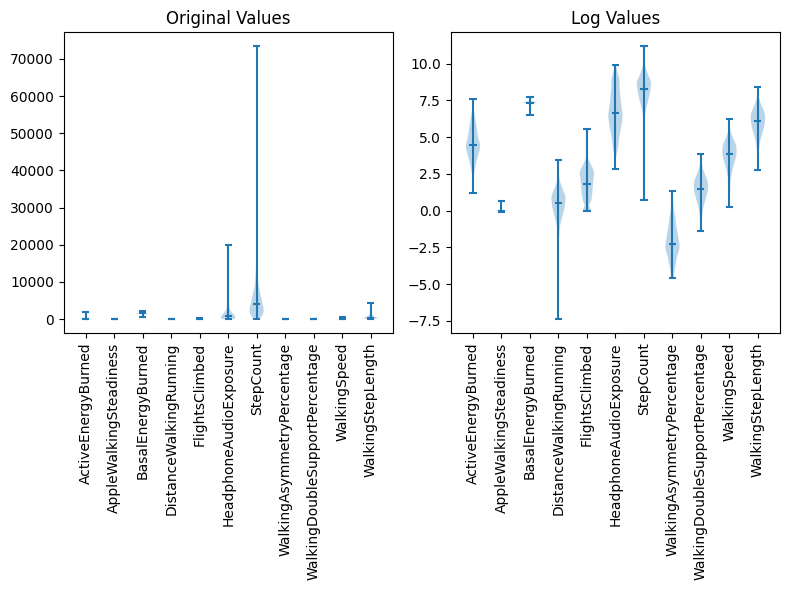

In [ ]:
# Create empty list to store filtered DataFrames
filts = []
logfilts = []

# Apply filters, append to list
for label in unique_recTypes:
    filt = sums['value'][sums['recordType'] == label]
    filts.append(filt)
    f4l = filt[filt != 0]
    logfilts.append(np.log(f4l))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# First subplot - normal values
axes[0].violinplot(filts,
                   showmeans=False,
                   showmedians=True)
axes[0].set_xticks(np.arange(1, len(unique_recTypes) + 1))
axes[0].set_xticklabels(unique_recTypes, rotation=90)
axes[0].set_title('Original Values')

# Second subplot - log-transformed values
axes[1].violinplot(logfilts,
                   showmeans=False,
                   showmedians=True)
axes[1].set_xticks(np.arange(1, len(unique_recTypes) + 1))
axes[1].set_xticklabels(unique_recTypes, rotation=90)
axes[1].set_title('Log Values')

plt.tight_layout()
plt.show()


Step count has a much higher maximum value than the other metrics, but headphone audio exposure and walking step length also show a greater amount of variability. This confirms it would be a good idea to scale the variables before doing anything fancy with them - otherwise the variables with greater variance will dominate outcomes. The `StandardScaler` from SciKitLearn will scale variables so they all have a mean of 0 and a standard deviation of 1. <br>

Additionally, the distributions are very right-skewed (very concentrated around 0) so we will want to account for that in any models we fit to this data (e.g., make sure we don't use a model that assumes a gaussian distribution). For now, let's just take care of scaling the data so all variables have comparable variance, and replacing dates post-record-type-introduction with zeros:

In [ ]:
# Pivot sums so each record type has its own column:
unscaled_dat = sums.pivot(index='creationDate', columns='recordType', values='value').reset_index()
unscaled_dat['creationDate'] = pd.to_datetime(unscaled_dat['creationDate'])

# Replace NaNs with 0s if the record is after record type beginning, also identify outliers
mv_before = unscaled_dat.isnull().sum() # count missing values for each record type
is_outlier = np.zeros(unscaled_dat.shape)

# Replace NaNs with 0s if the record is record type beginning
for column in unscaled_dat:
  if column == 'creationDate':
    continue # min_dates doesn't have entry for creationDate so skip this one.
  # unscaled_dat[column] = unscaled_dat[column] + 1 # add one to everything so nothing is between 0 and 1 (for log transform)
  out_thresh = [unscaled_dat[column].mean()-unscaled_dat[column].std()*3.5, unscaled_dat[column].mean()+unscaled_dat[column].std()*3.5]
  is_outlier[:,unscaled_dat.columns.get_loc(column)] = (unscaled_dat[column] > out_thresh[0]) | (unscaled_dat[column] < out_thresh[1])
  min_date_for_column = min_dates[unscaled_dat.columns.get_loc(column)-1] # "-1" due to extra col for creation date in df
  unscaled_dat[column] = np.where(
      (unscaled_dat['creationDate'].dt.date >= min_date_for_column.date()), unscaled_dat[column].fillna(0), unscaled_dat[column]
  )

print("\n** Change in missing values before vs after replacing post-start NaNs **\n")
mv_after = unscaled_dat.isnull().sum()
mv_df = pd.DataFrame({'Before': mv_before, 'After': mv_after})
print(mv_df)

# Scale values for each record type so mean = 0 and st. dev. = 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # set scaling type from SKLearn
display(unscaled_dat.drop(columns='creationDate').head())
scaled_dat = scaler.fit_transform(unscaled_dat.drop(columns='creationDate'))

# Make it a dataframe:
df_sc = pd.DataFrame(scaled_dat, columns=unique_recTypes)
df_sc.insert(0, 'CreationDate', unique_creationDate)

print("\n** Scaled Data **\n")
display(df_sc.head())


** Change in missing values before vs after replacing post-start NaNs **

                                Before  After
recordType                                   
creationDate                         0      0
ActiveEnergyBurned                1632   1632
AppleWalkingSteadiness            2335   1253
BasalEnergyBurned                 1632   1632
DistanceWalkingRunning              46      0
FlightsClimbed                     411      1
HeadphoneAudioExposure            1687    569
StepCount                           47      0
WalkingAsymmetryPercentage        1067    870
WalkingDoubleSupportPercentage     925    870
WalkingSpeed                       923    870
WalkingStepLength                  923    870


recordType,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
0,NaN,NaN,NaN,1.566136,NaN,NaN,3519.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.558532,1.0,NaN,1304.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,2.265880,0.0,NaN,5603.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.175429,0.0,NaN,2824.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,4.707403,9.0,NaN,10658.0,NaN,NaN,NaN,NaN



** Scaled Data **



,CreationDate,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
0,2018-05-17,NaN,NaN,NaN,-0.303463,NaN,NaN,-0.349041,NaN,NaN,NaN,NaN
1,2018-05-18,NaN,NaN,NaN,-0.745991,-0.534388,NaN,-0.766681,NaN,NaN,NaN,NaN
2,2018-05-19,NaN,NaN,NaN,0.003856,-0.603582,NaN,0.043900,NaN,NaN,NaN,NaN
3,2018-05-20,NaN,NaN,NaN,-0.475057,-0.603582,NaN,-0.480083,NaN,NaN,NaN,NaN
4,2018-05-21,NaN,NaN,NaN,1.076145,0.019164,NaN,0.997025,NaN,NaN,NaN,NaN


## Visualizing how activity metrics vary over time
Now that the data has been scaled such that no variable will dominate analyses, and missing values have been explained and addressed, let's see how these scaled records vary over time.

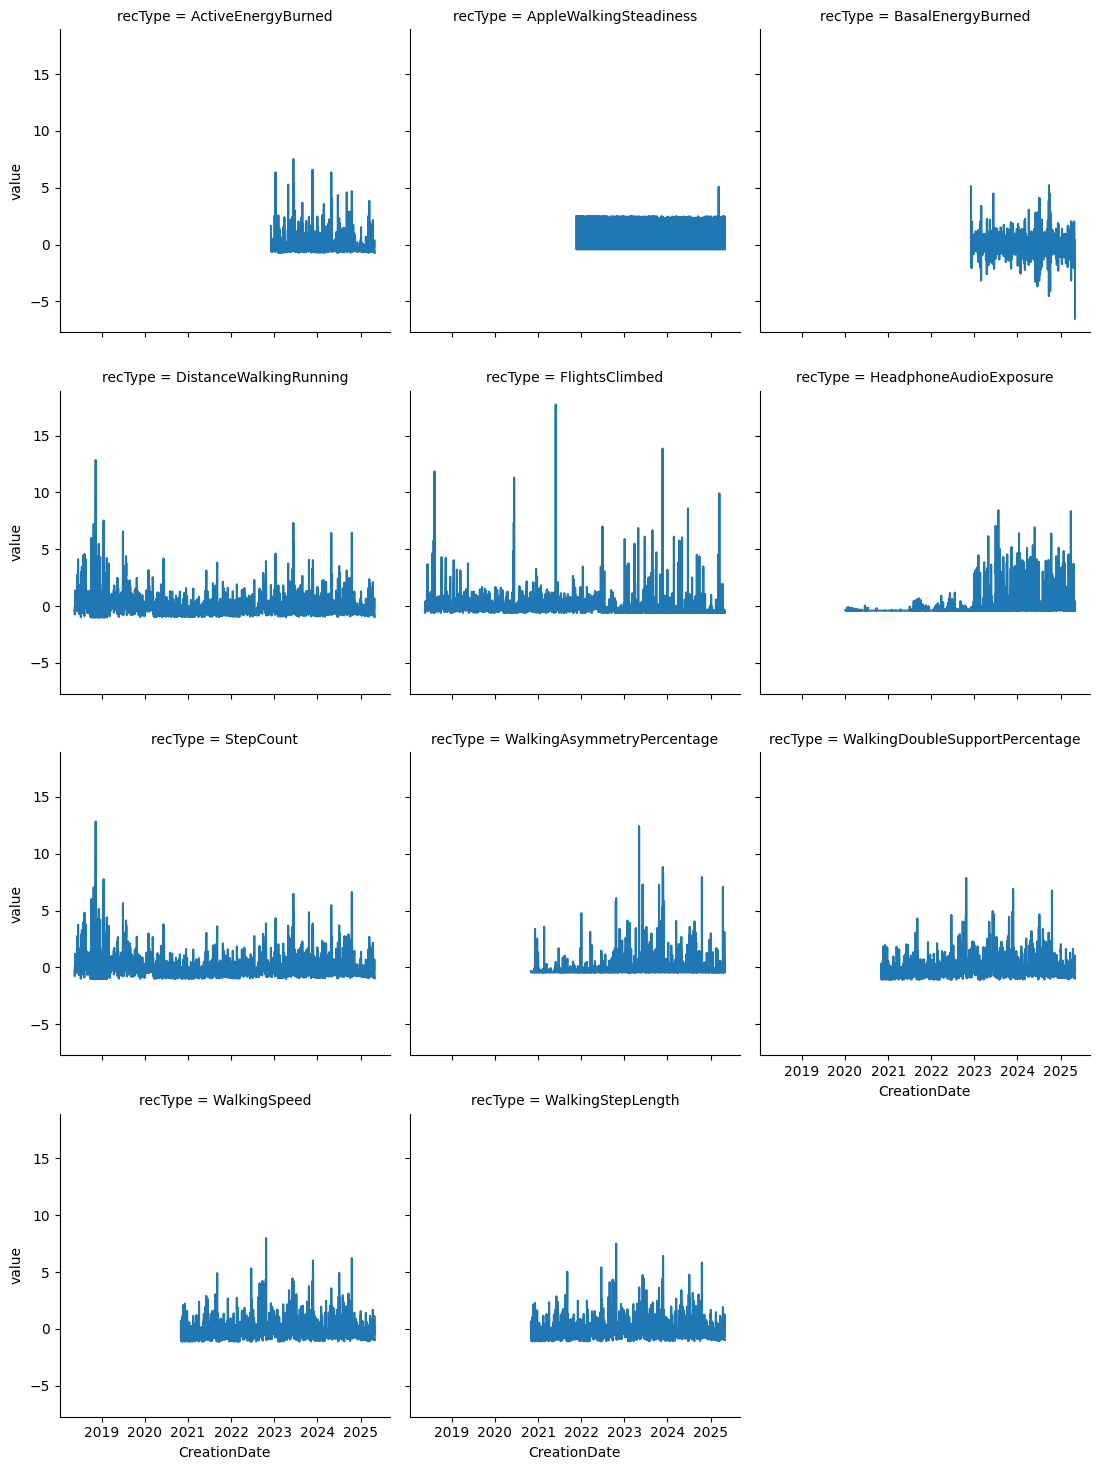

In [ ]:
# unpivot the data frame so each row is a distinct recordtype
df_sc_long = df_sc.melt(id_vars=['CreationDate'],
                    value_vars=unique_recTypes,
                    var_name='recType',
                    value_name='value')

# make faceted plot
import seaborn as sns
sns.relplot(data=df_sc_long, x='CreationDate', y='value', kind='line', col='recType', col_wrap=3,  height=3.7, aspect=1)  # Adjust col_wrap as needed
plt.tight_layout()
plt.show()

One more thing - it's notable that this data comes from three different devices (iPhone 10, 13 and 15): I'm curious whether this change impacted how metrics were recorded? We can look for inflection points in the data caused by a hardware change by color-coding the line plots above by `svHardware`.

,CreationDate,recType,value,Hardware
0,2018-05-17,ActiveEnergyBurned,NaN,"iPhone10,4"
1,2018-05-18,ActiveEnergyBurned,NaN,"iPhone10,4"
2,2018-05-19,ActiveEnergyBurned,NaN,"iPhone10,4"
3,2018-05-20,ActiveEnergyBurned,NaN,"iPhone10,4"
4,2018-05-21,ActiveEnergyBurned,NaN,"iPhone10,4"


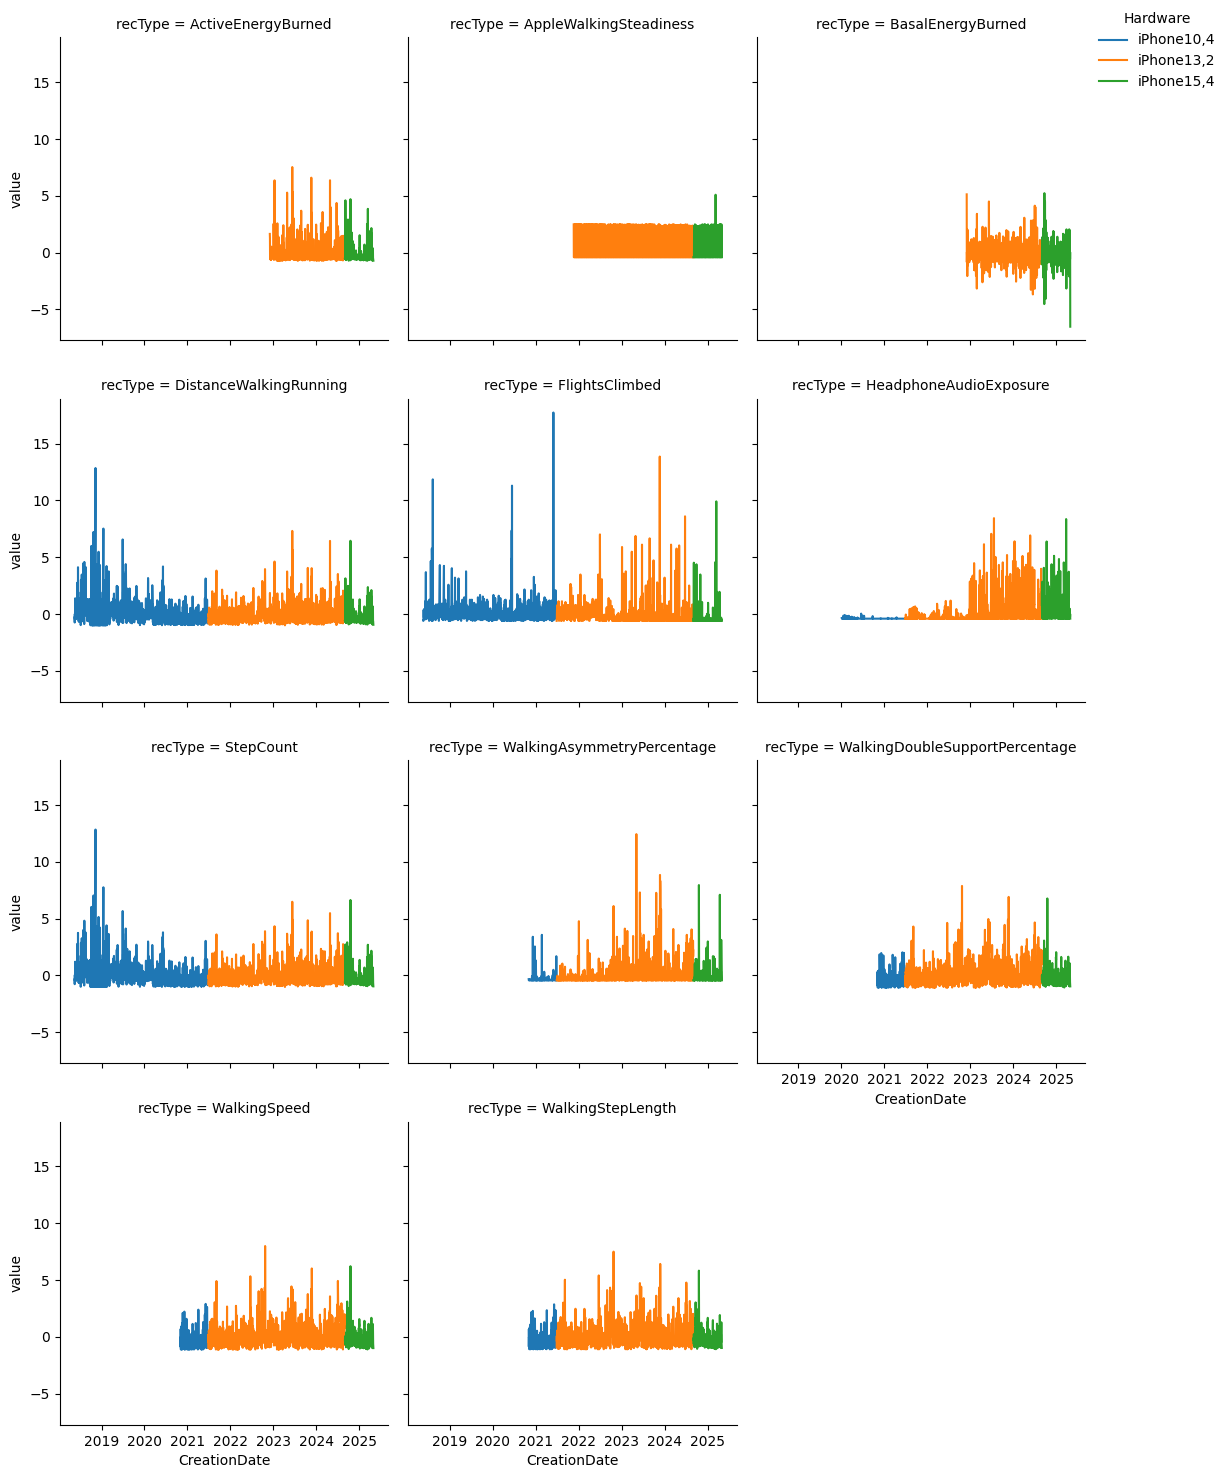

In [ ]:
# identify dominant hardware (most counts) for each date
hw_bydate = df_sp.groupby([df_sp['creationDate'].dt.date, 'svHardware'])['value'].count().reset_index().pivot(index='creationDate', columns='svHardware', values='value').idxmax(axis = "columns").reset_index()
hw_bydate.columns = ['CreationDate','Hardware']

# join to df_sc_long
df_sc_long_whw = df_sc_long.copy() # new version with hardware
df_sc_long_whw = df_sc_long_whw.set_index(pd.to_datetime(df_sc_long_whw['CreationDate'])) # set CreationDate as indexing variable for merge
df_sc_long_whw = pd.merge(df_sc_long_whw, hw_bydate, left_index=True, right_on=pd.to_datetime(hw_bydate['CreationDate']), how='left') # merge hardware info
df_sc_long_whw = df_sc_long_whw.drop(columns = ['CreationDate_x','CreationDate_y']).rename(columns={'key_0': 'CreationDate'}) # tidy up columns
display(df_sc_long_whw.head())

# make new plot
g = sns.relplot(data=df_sc_long_whw, x='CreationDate', y='value', hue = 'Hardware', kind='line', col='recType', col_wrap=3,  height=3.7, aspect=1)  # Adjust col_wrap as needed
sns.move_legend(g, "upper right")
plt.show()

There don't seem to be any visible inflection points at hardware change dates for any of the record types - however, it will still probably be a good idea to account for hardware type as a random effect where relevant, as there may still be less obvious differences.
<br><br>
While we're thinking about hardware, let's take a look at how headphone type (specified by `svName`) impacts the headphone audio exposure record type:

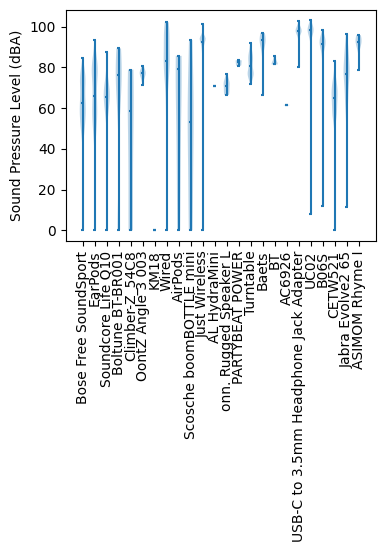

In [ ]:
headphone_types = df_sp['svName'][df_sp['recordType']=='HeadphoneAudioExposure'].unique()

hpfilts = []

# Apply filters and append to the list
for hp in headphone_types:
    filt = df_sp['value'][(df_sp['recordType'] == 'HeadphoneAudioExposure') & (df_sp['svName'] == hp)] # find all the values where
    hpfilts.append(filt)

# plot violin plot
plt.figure(figsize = (4,3))
plt.violinplot(hpfilts,
                  showmeans=False,
                  showmedians=True)
plt.ylabel('Sound Pressure Level (dBA)')
plt.xticks(np.arange(1, len(headphone_types) + 1), headphone_types)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

This visualization shows that the audio exposure metric varies a lot by headphone type - since I'm not interested into diving into headphone types and controlling for that here, I'll exclude this record type from all further analyses.

Let's see if we can distinguish between daily health metrics in the spring, summer, fall and winter, based on this health data. Since Active Energy Burned and Basal Energy Burned are known to be pretty inaccurate for users who don't have an Apple Watch (I don't), and since Apple Walking Steadiness didn't get recordings until late 2021, we'll exclude those 3 inputs from the next section so we have more examples. Also, since Headphone Audio Exposure varies a lot based on type of headphones, we'll exclude that variable too.

## Exploring data variance using principal component analysis

Let's use PCA to see if the input variables show certain dimensions of greatest variance: basically, what are the types of differences between days that best account for variability across this data?


In [ ]:
from sklearn.decomposition import PCA

df_sc_lr = df_sc.drop(columns=['HeadphoneAudioExposure', 'ActiveEnergyBurned', 'BasalEnergyBurned', 'AppleWalkingSteadiness']) # removing certain vars, as discussed above
df_sc_lr = df_sc_lr[pd.to_datetime(df_sc_lr['CreationDate']) > pd.to_datetime('2020-10-31')] # only after most metrics have been introduced.
features_for_pca = df_sc_lr.drop(columns=['CreationDate'])

# Apply PCA
pca = PCA()
pca.fit(features_for_pca)

# Determine the number of principal components to retain (e.g., explaining 95% of variance)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
var_thresh = 0.95
n_components = np.argmax(cumulative_variance >= var_thresh) + 1  # Adjust threshold as needed
print(f"Number of components explaining at least {var_thresh*100}% variance: {n_components}")

# How are the input variables weighed across the top 3 PCs?
principal_components = pd.DataFrame(pca.components_,columns=features_for_pca.columns)
display(principal_components.loc[0:2,])

Number of components explaining at least 95.0% variance: 3


,DistanceWalkingRunning,FlightsClimbed,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
0,0.363492,0.174848,0.374798,0.326472,0.441409,0.443166,0.446100
1,0.204380,0.877561,0.193448,-0.269649,-0.192281,-0.144728,-0.141646
2,-0.087760,0.205248,-0.070827,0.901903,-0.141326,-0.254190,-0.217118


We can visualize the top 3 PCs, which account for 95% of variance in this data, to more easily try to decode what kind of information each contains.
 *You can play around with the value of `var_thresh` in the code above to see how different amounts of variance are explained - for example, just 2 dimensions explain 85% of variance, and 4 dimensions explain 98% of variance.*

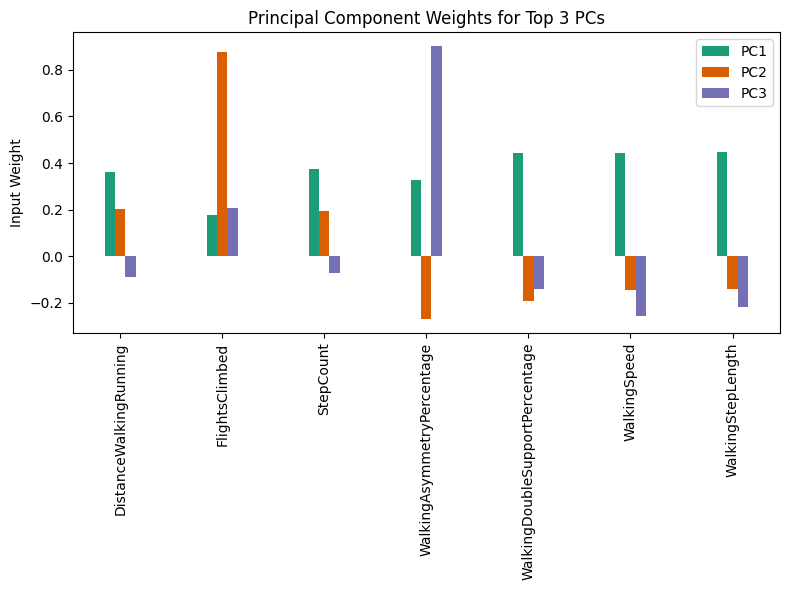

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

width = 0.1
pc_labels = ['PC1', 'PC2', 'PC3']
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d']

x_positions = [i for i in range(len(principal_components.columns))]
for i, pc in enumerate(principal_components.index[:3]):
    offsets = [j * width for j in range(3)]
    ax.bar([pos + offsets[i] for pos in x_positions], principal_components.loc[pc,:], width, label=pc_labels[i], color=colors[i])

ax.set_xticks([pos + width for pos in x_positions])
ax.set_xticklabels(principal_components.columns)
ax.tick_params(axis='x', labelrotation=90) # Rotates X-axis labels for better readability
ax.set_ylabel('Input Weight')
ax.set_title('Principal Component Weights for Top 3 PCs')
ax.legend()

plt.tight_layout()
plt.show()


The plot above suggests that PC1 (shown in teal), which seems to be pretty evenly spread across the metrics, distinguishes overall between more active and less active days. <br><br>

PC2 and PC3 are a bit more interesting: PC2 has a strong positive weight for Flights Climbed and a negative weight on Walking Asymmetry Percentage. Apple defines Walking Asymmetry Percentage as *the percentage of steps in which one foot moves at a different speed than the other when walking on flat ground*, so I interpret this type of variance as identifying days when I gain a lot of altitude and walked very symmetrically (since it's a *negative* weight on *a*-symmetry). PC3, inversely, has a weaker, positive weight on Flights Climbed and a strong positive weight on asymmetry - this suggests to me that PC2 is for days I do long hikes on relatively even paths or roads, versus PC3 is for days where I do hikes on uneven pathways that involve a lot of careful footing or scrambling. This is supported by the fact that Distance Walking Running is positive for PC2 but negative for PC3 - it's harder to cover a lot of ground when you're climbing a lot. <br><br>
To do one final exploration of what these PCs mean, I'm going to look at some dates when PC1, PC2, or PC3 are particularly high, and reference my calendar to see what I was up to those days.

In [ ]:
# Create new data frame with by-date data transformed w.r.t PCs
df_sc_pc = pd.DataFrame(pca.transform(features_for_pca))
df_sc_pc.insert(0, 'CreationDate', df_sc_lr['CreationDate'].to_numpy())
df_sc_pc.columns = ['CreationDate'] + [f'PC{i+1}' for i in range(features_for_pca.shape[1])]

display(df_sc_pc.head())

# Get top 2 max and top 2 min dates for each of PC1, PC2, and PC3
for pci in ['PC1', 'PC2', 'PC3']:
  print(f"\n*** Top 2 and bottom 2 dates for {pci}: ***")
  print("\ntop:",df_sc_pc['CreationDate'].loc[df_sc_pc.nlargest(2,pci).index])
  print("\nbottom:",df_sc_pc['CreationDate'].loc[df_sc_pc.nsmallest(2,pci).index])

,CreationDate,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,2020-11-01,0.925638,1.131094,-0.370455,-0.689662,-0.231878,-0.036827,-0.003492
1,2020-11-02,-1.867854,0.133729,0.240471,-0.140471,-0.027549,-0.011389,0.000079
2,2020-11-03,-0.465997,0.223015,-0.240956,-0.448873,-0.083736,-0.027910,0.025445
3,2020-11-04,-0.432979,0.479714,-0.173028,-0.352429,-0.035107,-0.040329,0.028559
4,2020-11-05,-0.510124,0.556937,-0.128486,-0.193125,-0.072526,-0.031596,-0.019436



*** Top 2 and bottom 2 dates for PC1: ***

top: 1448    2024-10-19
722     2022-10-24
Name: CreationDate, dtype: object

bottom: 77    2021-01-17
75    2021-01-15
Name: CreationDate, dtype: object

*** Top 2 and bottom 2 dates for PC2: ***

top: 210     2021-05-30
1115    2023-11-21
Name: CreationDate, dtype: object

bottom: 916    2023-05-06
722    2022-10-24
Name: CreationDate, dtype: object

*** Top 2 and bottom 2 dates for PC3: ***

top: 916     2023-05-06
1117    2023-11-23
Name: CreationDate, dtype: object

bottom: 308    2021-09-05
307    2021-09-04
Name: CreationDate, dtype: object


For PC1 the max dates are October 19th, 2024 and October 24th, 2022. Remember that PC1 we've interpreted to be a metric of overall activity, particularly driven by distance walked / steps taken. Looking at my calendar, on October 19th, 2024, I was at a music festival in Las Vegas (lots of standing, power-walking from one stage to another, shuffling around in the crowd to get a better view). On October 24th, 2022, I was... also in Las Vegas for that same music festival! So it looks like this is a good proxy for a lot of walking and consistent motion throughout the day.

In [ ]:
unscaled_dat[(unscaled_dat['creationDate'] == '2022-10-24') | (unscaled_dat['creationDate'] == '2024-10-19')]

recordType,creationDate,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
1592,2022-10-24,NaN,0.0,NaN,9.027413,8.0,301.1627,21203.0,1.91,48.139,502.08036,4428.7385
2318,2024-10-19,1309.016,0.0,1649.971,16.936781,0.0,0.0000,40590.0,2.45,42.214,404.08022,3565.7453


The minimum dates for PC1 are January 15th and 17th of 2021. 2021 was a weird time (deep pandemic) and this was winter, so it wouldn't surprise me that I was very sedentary these dates. Looking at my calendar, there's no events scheduled and these dates fall on a Friday and Saturday, so it's very possible I did almost nothing! Good times...

In [ ]:
unscaled_dat[(unscaled_dat['creationDate'] == '2021-01-15') | (unscaled_dat['creationDate'] == '2021-01-17')]

recordType,creationDate,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
945,2021-01-15,NaN,NaN,NaN,0.043235,1.0,0.0,96.0,0.0,0.0,0.0,0.0
947,2021-01-17,NaN,NaN,NaN,0.069792,0.0,0.0,158.0,0.0,0.0,0.0,0.0


Moving on to PC2, the max dates are May 30th, 2021 and November 21st, 2023. Both of these show over 200 flights climbed - on the 2021 date I did a segment of the Mauna Loa trail in Hawaii, and on the 2023 date I climbed Mount Halasan in South Korea. The minimum dates are May 6th, 2023 (I went to DisneyWorld with my nephew) and October 24th, 2022 (going to shows / visiting casinos in Vegas). Interestingly, both ends of the spectrum are pretty active days, but the upper end involves lots of elevation gain and uneven ground, while the lower end is entirely on level, human-made surfaces.

In [ ]:
unscaled_dat[(unscaled_dat['creationDate'] == '2021-05-30') | (unscaled_dat['creationDate'] == '2023-11-21') |
              (unscaled_dat['creationDate'] == '2023-05-06') | (unscaled_dat['creationDate'] == '2022-10-24')]

recordType,creationDate,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
1080,2021-05-30,NaN,NaN,NaN,5.380693,265.0,0.0000,12900.0,0.27,6.256,78.71779,781.1025
1592,2022-10-24,NaN,0.0,NaN,9.027413,8.0,301.1627,21203.0,1.91,48.139,502.08036,4428.7385
1786,2023-05-06,485.548,1.0,1698.259,7.273760,3.0,0.0000,19870.0,3.76,23.783,241.45492,2285.8248
1985,2023-11-21,1764.371,0.0,1826.309,9.789589,209.0,0.0000,25151.0,0.16,8.843,90.73014,907.4803


Last, and least since it only accounts for about 10% of variance, we look at PC3: The max dates are May 6th, 2023 (again, DisneyWorld with my nephew) and November 23rd, 2023 (walking around Seogwipo market in South Korea). The min dates are September 4th and 5th of 2021, which was when I was on a girls trip in New York City (*lots* of walking). As we might expect from looking at the bar graph, the primary noticeable difference between these sets of dates was that my Walking Asymmetry was notably higher for the max dates - I believe I was carrying bags or babies on both of these days.

In [ ]:
unscaled_dat[(unscaled_dat['creationDate'] == '2021-09-04') | (unscaled_dat['creationDate'] == '2023-11-23') |
              (unscaled_dat['creationDate'] == '2023-05-06') | (unscaled_dat['creationDate'] == '2021-09-05')]

recordType,creationDate,ActiveEnergyBurned,AppleWalkingSteadiness,BasalEnergyBurned,DistanceWalkingRunning,FlightsClimbed,HeadphoneAudioExposure,StepCount,WalkingAsymmetryPercentage,WalkingDoubleSupportPercentage,WalkingSpeed,WalkingStepLength
1177,2021-09-04,NaN,NaN,NaN,9.875906,10.0,0.0,22793.0,0.08,22.099,274.15891,2617.3251
1178,2021-09-05,NaN,NaN,NaN,10.959949,14.0,0.0,24529.0,0.19,28.901,331.93894,3153.5448
1786,2023-05-06,485.548,1.0,1698.259,7.273760,3.0,0.0,19870.0,3.76,23.783,241.45492,2285.8248
1987,2023-11-23,393.500,0.0,1682.673,4.675801,14.0,0.0,11955.0,2.71,21.878,185.33015,1859.0538


These observations mostly align with the interpretations we cobbled together from the bar graph above - PC1 is primarily about overall activity, while PC2 is about flat city walking versus uneven hiking with elevation gain, and PC3 is driven by asymmetry. The only surprise to me was that high-PC3 days were not hiking days - it seems that hiking on natural surfaces doesn't imply walking asymmetry, as seen by PC2 maxing out on hiking days and having a negative weight on asymmetry.

The beautiful thing about dimensionality reduction is just what the name suggests - our dimensionality has been reduced! Instead of 7 variables to worry about, we can focus on just 3 that we know account for 95% of the information that the larger data set contains, and use that to explore relationships between my activity and external factors, such as time of week and time of year.

## Am I more active during certain seasons?
First I need to categorize `CreationDate` based on season - I'll do this by calculating which seasonal high point (solstice or equinox) each date is closest to. This is a coarse way to distinguish times of year, but much easier than splitting by that day's weather data, which would need to account for my location on the date in question.

In [ ]:
winter_dt = '-12-21' # winter solstice
fall_dt = '-09-20' # fall equinox
summer_dt = '-06-20' # summer solstice
spring_dt = '-03-20' # spring equinox
df_sc_pc['SeasonCat'] = 0 # initialize the season category variable

for index, row in df_sc_pc.iterrows():
    current_date = pd.to_datetime(row['CreationDate'])
    cy = current_date.year
    py = cy - 1

    # define summer & winter dates surrounding current date
    spring_date = pd.to_datetime((str(cy)+spring_dt))
    summer_date = pd.to_datetime((str(cy)+summer_dt))
    fall_date = pd.to_datetime((str(cy)+fall_dt))
    winter_dates = [pd.to_datetime((str(cy)+winter_dt)),pd.to_datetime((str(py)+winter_dt))]

    # calculate num days between current date and summer/winter dates
    diffs = np.array([abs((current_date - spring_date).days), # spring
                      abs((current_date - summer_date).days), # summer
                      abs((current_date - fall_date).days), # fall
                      min(abs((current_date - winter_dates[0]).days),abs((current_date - winter_dates[1]).days)) # winter
                      ])

    # get index of minimum diff from diffs
    df_sc_pc.loc[index, 'SeasonCat'] = np.argmin(diffs) # 0 means spring, 1 means summer, 2 means fall, 3 means winter

display(df_sc_pc[['CreationDate','SeasonCat']].sample(n=10))

,CreationDate,SeasonCat
843,2023-02-22,0
41,2020-12-12,3
617,2022-07-11,1
346,2021-10-13,2
747,2022-11-18,3
984,2023-07-13,1
631,2022-07-25,1
1068,2023-10-05,2
774,2022-12-15,3
1366,2024-07-29,1


Now let's visualize whether PCs 1, 2 or 3 tend to meaningfully vary based on the season!

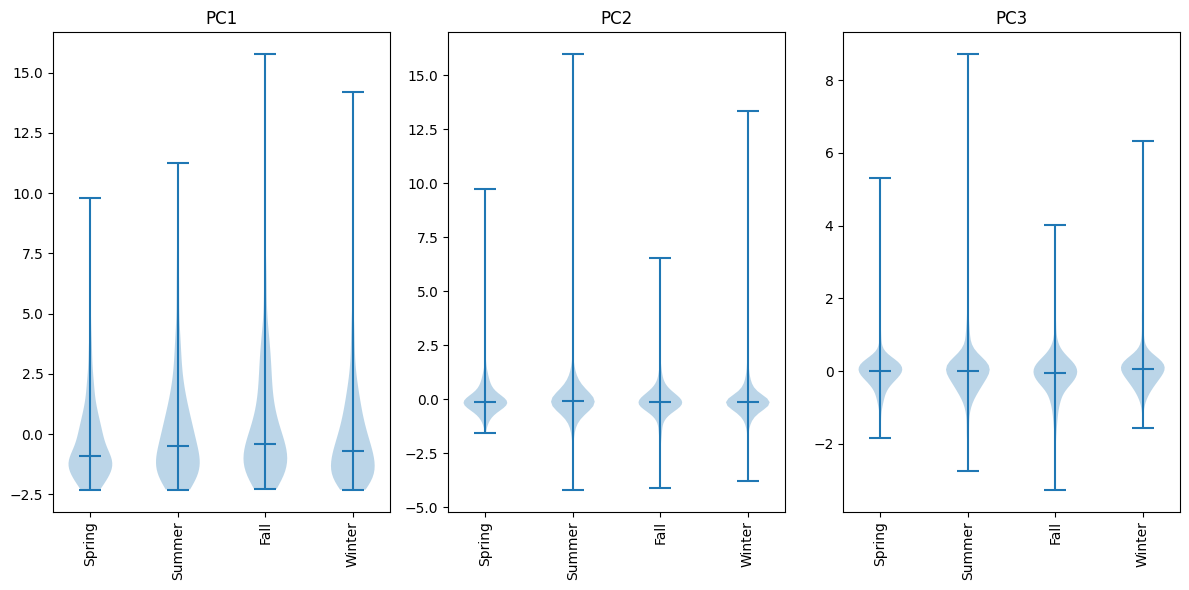

In [ ]:
# Create empty list to store filtered DataFrames
pc1filts = []
pc2filts = []
pc3filts = []
seasons = ['Spring','Summer','Fall','Winter']
# Apply filters, append to list
for sind in range(len(seasons)):
    pc1filt = df_sc_pc['PC1'][df_sc_pc['SeasonCat'] == sind]
    pc2filt = df_sc_pc['PC2'][df_sc_pc['SeasonCat'] == sind]
    pc3filt = df_sc_pc['PC3'][df_sc_pc['SeasonCat'] == sind]
    pc1filts.append(pc1filt)
    pc2filts.append(pc2filt)
    pc3filts.append(pc3filt)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# PC1
axes[0].violinplot(pc1filts,
                   showmeans=False,
                   showmedians=True)
axes[0].set_xticks(np.arange(1, len(seasons) + 1))
axes[0].set_xticklabels(seasons, rotation=90)
axes[0].set_title('PC1')

# PC2
axes[1].violinplot(pc2filts,
                   showmeans=False,
                   showmedians=True)
axes[1].set_xticks(np.arange(1, len(seasons) + 1))
axes[1].set_xticklabels(seasons, rotation=90)
axes[1].set_title('PC2')

# PC3
axes[2].violinplot(pc3filts,
                   showmeans=False,
                   showmedians=True)
axes[2].set_xticks(np.arange(1, len(seasons) + 1))
axes[2].set_xticklabels(seasons, rotation=90)
axes[2].set_title('PC3')

plt.tight_layout()
plt.show()

Interestingly, there are no remarkable distinctions for any of the three PCs across seasons: PC1 has a bit less positive skew in the fall, and PCs 2 and 3 show more variance in the summer than any time, but this view isn't a compelling case for the activity data having potential to predict the season.<br><br>
We'll bring this back when we investigate these relationships using GLMs, but for now let's try visualizing activity differences on weekends versus weekdays!

## Am I more active on the weekends?
We'll start by making a dummy variable: Saturdays and Sundays are 1, the rest are 0.

In [ ]:
df_sc_pc['CreationDate'] = pd.to_datetime(df_sc_pc['CreationDate'])
df_sc_pc['day_of_week_int'] = df_sc_pc['CreationDate'].dt.dayofweek
df_sc_pc['is_weekend'] = 0
df_sc_pc.loc[df_sc_pc['day_of_week_int'] > 4, 'is_weekend'] = 1 # marks Saturday as 1

Now let's see how the PCs compare for weekend versus weekday.

Text(0.5, 1.0, 'PC3')

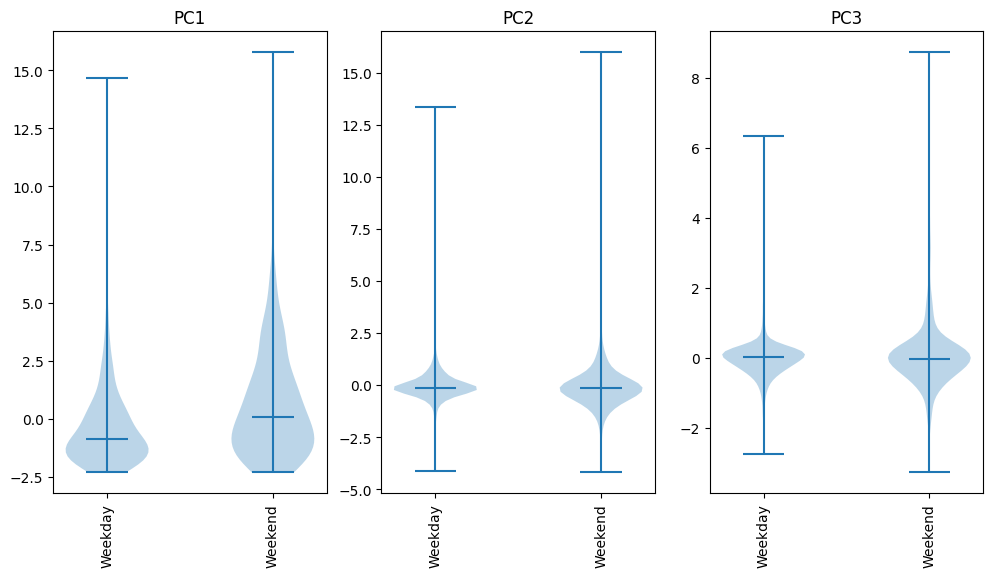

In [ ]:
# Create empty list to store filtered DataFrames
pc1filtsW = []
pc2filtsW = []
pc3filtsW = []
daytype = ['Weekday','Weekend']
# Apply filters, append to list
for dind in range(len(daytype)):
    pc1filt = df_sc_pc['PC1'][df_sc_pc['is_weekend'] == dind]
    pc2filt = df_sc_pc['PC2'][df_sc_pc['is_weekend'] == dind]
    pc3filt = df_sc_pc['PC3'][df_sc_pc['is_weekend'] == dind]
    pc1filtsW.append(pc1filt)
    pc2filtsW.append(pc2filt)
    pc3filtsW.append(pc3filt)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# PC1
axes[0].violinplot(pc1filtsW,
                   showmeans=False,
                   showmedians=True)
axes[0].set_xticks(np.arange(1, len(daytype) + 1))
axes[0].set_xticklabels(daytype, rotation=90)
axes[0].set_title('PC1')

# PC2
axes[1].violinplot(pc2filtsW,
                   showmeans=False,
                   showmedians=True)
axes[1].set_xticks(np.arange(1, len(daytype) + 1))
axes[1].set_xticklabels(daytype, rotation=90)
axes[1].set_title('PC2')

# PC3
axes[2].violinplot(pc3filtsW,
                   showmeans=False,
                   showmedians=True)
axes[2].set_xticks(np.arange(1, len(daytype) + 1))
axes[2].set_xticklabels(daytype, rotation=90)
axes[2].set_title('PC3')

This looks more promising! Particularly for PC1, it looks like there's a notable difference in value distribution between weekdays and weekends. Let's use a generalized linear model to determine whether this is a statistically significant difference.

## Defining statistical relationships using GLMs
Our next step is fitting a statistical model to determine whether weekday/weekend or season impacts my activity - from visual inspection of the plots above, I'd guess yes for weekend/weekday and no for seasons, but there's a reason statistics exist! We can't always see relationships with the naked eye. We'll fit a generalized linear model with a Gamma distribution and a log-link (to account for the skewed nature of the distribution). Let's start with just the weekend/weekday distinction, as it makes for a nice simple model:



In [ ]:
import statsmodels.api as sm

# Set up dependent & independent variables
x = df_sc_pc['is_weekend']
y = df_sc_pc['PC1']
y = y + np.abs(np.floor(y.min())) # add constant to make all PC1 values positive
y = y.values.reshape(-1, 1)
x = sm.add_constant(x) # So that the model includes an intercept

# Fit the GLM model
gamma_model = sm.GLM(y, x, family=sm.families.Gamma(link=sm.families.links.Log())) # Gamma with Log link
gamma_results = gamma_model.fit()
df_sc_pc['resid_dev'] = gamma_results.resid_deviance # adding this in for later outlier removal

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1644
Model:                            GLM   Df Residuals:                     1642
Model Family:                   Gamma   Df Model:                            1
Link Function:                    Log   Scale:                         0.48839
Method:                          IRLS   Log-Likelihood:                -3110.1
Date:                Fri, 16 May 2025   Deviance:                       636.03
Time:                        00:06:45   Pearson chi2:                     802.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.04205
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9985      0.020     48.977      0.0

At first glance, the p-value for the `is_weekend` effect is very small, suggesting that the effect is likely signficant, and that we can reject the hypothesis that activity levels (for which PC1 is a proxy) are similar on weekends and weekdays. Additionally, the 95% confidence interval ranges from 0.239 to 0.389, demonstrating that PC1 is very likely to be greater on weekends than on weekdays (since both these values are positive). The coefficient of interest is 0.3141, but since we're using the log-link (as opposed to identity-link, which is commonly used when the distribution family is Gaussian), this represents the coefficient for the *log* of the dependent variable: We need to exponentiate the coefficient to make it more interpretable. *exp*(0.3141) = 1.369, so overall activity is **roughly 36.9% higher on weekends than on weekdays**.

One final observation: the Pseudo R-Squared value estimates that only 4% of the variance in PC1 is explained by this model - this makes sense since it's a very simple model, with only one independent variable. What happens if we add in our categorical variable for season, to investigate whether there are interactions between weekend and weekday with time of year? In other words, posing the question: does the difference in activity for weekdays versus weekends vary by season?

In [ ]:
import statsmodels.formula.api as smf

# make data frame for model fit
df_formod = df_sc_pc[['SeasonCat','is_weekend','PC1']].copy()
df_formod['SeasonCat'] = df_formod['SeasonCat'].astype("category")
df_formod['PC1'] = df_formod['PC1']  + np.abs(np.floor(df_formod['PC1'].min())) # normalize PC1 again
df_formod.columns = ['season','weekend','activity']

# fit Gamma GLM
itxn_model = smf.glm(
    formula="activity ~ C(weekend) * C(season)",
    data=df_formod,
    family=sm.families.Gamma(link=sm.families.links.Log())
)

itxn_result = itxn_model.fit()

# View the summary
print(itxn_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               activity   No. Observations:                 1644
Model:                            GLM   Df Residuals:                     1636
Model Family:                   Gamma   Df Model:                            7
Link Function:                    Log   Scale:                         0.46378
Method:                          IRLS   Log-Likelihood:                -3079.9
Date:                Fri, 16 May 2025   Deviance:                       618.45
Time:                        00:06:47   Pearson chi2:                     759.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.06602
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

All 3 p-values for the interaction effects are above 0.1, and the confidence intervals include 0, so it does not seem that season significantly impacts the weekend vs weekday effect on activity. Now that we know the interaction is not significant, let's look at a model with just main effects to investigate whether seasons explain variance in activity beyond that explained by weekend vs weekday.

In [ ]:
# fit Gamma GLM
mefs_model = smf.glm(
    formula="activity ~ C(weekend) + C(season)",
    data=df_formod,
    family=sm.families.Gamma(link=sm.families.links.Log())
)

mefs_result = mefs_model.fit()

# View the summary
print(mefs_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               activity   No. Observations:                 1644
Model:                            GLM   Df Residuals:                     1639
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                         0.46224
Method:                          IRLS   Log-Likelihood:                -3080.2
Date:                Fri, 16 May 2025   Deviance:                       619.39
Time:                        00:06:50   Pearson chi2:                     758.
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06507
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8754      0.034     

It looks like season does, in fact, make a significant difference in activity levels! Levels 1 and 2 (summer and fall) are significantly greater than level 0 (spring) while winter does not differ significantly from spring. This tracks with my intuition, since spring has mostly been a continuation of winter in the places I've lived (lots of snow and sleet up until at least May 1st). You'll notice the effect size for seasonal differences is comparable for summer and fall relative to spring (23.4% and 27.3% more active, respectively). Both are smaller than the impact of weekend vs weekday, 36.6% more active on weekends, which is notably close to the estimate of this effect by the first, simple model we fit.